In [1]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###############################################################################
####################### EVALUATE SPINUP FOR LES DOMAINS #######################
###############################################################################

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as mpyplot
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [2]:
#%% Define file locations
WRF_DIRECTORY_SST34 = "/pl/active/JKL_IDEAL/hurricanes/sst_34/"  #  # NBA
# WRF_DIRECTORY_SST34 = "/rc_scratch/misa5952/hurricanes/sst_34/"    # "/rc_scratch/misa5952/hurricanes/sst_34/"  
WRF_DIRECTORY_SST32 = "/pl/active/JKL_IDEAL/hurricanes/sst_32/"  
WRF_DIRECTORY_SST30 = "/pl/active/JKL_IDEAL/hurricanes/sst_30/"  
WRF_DIRECTORY_SST28 = "/pl/active/JKL_IDEAL/hurricanes/sst_28/"  
WRF_DIRECTORY_SST26 = "/pl/active/JKL_IDEAL/hurricanes/sst_26/"    
# WRF_DIRS = [WRF_DIRECTORY_SST26,WRF_DIRECTORY_SST28,WRF_DIRECTORY_SST30,WRF_DIRECTORY_SST32,WRF_DIRECTORY_SST34,WRF_DIRECTORY_SST34_NBA]
WRF_DIRS = [WRF_DIRECTORY_SST26,WRF_DIRECTORY_SST28,WRF_DIRECTORY_SST30,WRF_DIRECTORY_SST32,WRF_DIRECTORY_SST34]

# Choose which domain to evaluate
domain = 'd04'

# Start time for simulations
startTime = np.datetime64('2000-01-01T00:00:00')

# Subsample data to reduce computational time and memory requirements
ss = 1

dirFig = "/pl/active/JKL_IDEAL/hurricanes/Figures/"



In [3]:
#%% Extract maximum wind speed data for each domain and hurricane combinations
# Initialize arrays that save max wind speed for each domain and hurricane
max_ws = np.zeros([len(WRF_DIRS),200000]) + np.nan # [hurricane, time]
time_ws = np.zeros([len(WRF_DIRS),200000]) + np.nan

## Choose height
iz_m = 0

# Extract and save maximum wind speed from time series output
for i_h in np.arange(len(WRF_DIRS)): # For each hurricane
    # Time series output for each restart
    if 'sst_26' in WRF_DIRS[i_h]:
        restarts = ['timeSeries_08-00__08-05','timeSeries_08-05__08-06']
    elif 'sst_28' in WRF_DIRS[i_h]:
        restarts = ['timeSeries_07-00_07-05','timeSeries_07-05__07-06'] #_newLocs
    elif 'sst_30' in WRF_DIRS[i_h]:
        restarts = ['timeSeries_07-07__07-11','timeSeries_07-11__07-12']
    elif 'sst_32' in WRF_DIRS[i_h]:
        restarts = ['timeSeries_07-00_07-05','timeSeries_07-04_07-05']
    elif 'sst_34' in WRF_DIRS[i_h]:
        restarts = ['timeSeries_07-18__07-22','timeSeries_07-20__07-21']
    #
    if domain=='d05':
        restarts = restarts[1]
    elif domain=='d04':
        restarts = restarts[0]

    # Station locations
    locs = np.loadtxt(WRF_DIRS[i_h] +restarts+ '/tslist_d04_d05.txt',skiprows=3,usecols=(2,3)) # [i,j]
    name_locs = np.loadtxt(WRF_DIRS[i_h] +restarts+ '/tslist_d04_d05.txt',skiprows=3,usecols=(1),dtype='U')
    # Define number of "stations" for high-temporal resolution data 
    if domain=='d05':
        which_stations = 'hi'
    elif domain=='d04':
        which_stations = 'lol'

    # Remove time series locations that are not going to be used in analysis
    stations = []
    for i in np.arange(len(name_locs)):
        if which_stations in name_locs[i]:
            stations = np.append(stations,i)
    stations = stations.astype('int')
#     stations = stations[:9]
    locs = locs[stations]
    name_locs = name_locs[stations]
    
    ## Extract data
    # Time arrays
    temp = np.loadtxt(WRF_DIRS[i_h]+restarts+'/'+name_locs[-1]+'.'+domain+'.UU',skiprows=1)
    init_temp = temp[:,0]
    time = temp[::ss,0]*(3600/1) # seconds since start of simulation
    time_sinceRst = time - time[0] # seconds since initialization
    TIME = startTime + time.astype('timedelta64[s]')
    # Height array
#     GHT = np.loadtxt(WRF_DIRS[i_h]+restarts+'/'+name_locs[0]+'.'+domain+'.PH',skiprows=1)
#     hgt_agl_stg = GHT[::ss,1:] - GHT[0,1]
#     hgt_agl_stg = np.mean(hgt_agl_stg,axis=0)
#     hgt_agl = 0.5*(hgt_agl_stg[1:] + hgt_agl_stg[0:-1])
#     hgt_agl = np.append(hgt_agl,hgt_agl[-1] + (hgt_agl[-1] - hgt_agl[-2]))
    # Initialize arrays [station,valForEachTimeStep,height]
    U = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
    V = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
    # Extract data for each station
    for i_s in np.arange(0,len(locs)):
        # Load data
        tempU = np.loadtxt(WRF_DIRS[i_h]+restarts+'/'+name_locs[i_s]+'.'+domain+'.UU',skiprows=1)
        tempV = np.loadtxt(WRF_DIRS[i_h]+restarts+'/'+name_locs[i_s]+'.'+domain+'.VV',skiprows=1)
        # Save data
        U[i_s,:,:] = tempU[:np.shape(init_temp)[0]:ss,1:]
        V[i_s,:,:] = tempV[:np.shape(init_temp)[0]:ss,1:]

        print('Done with %i out of %i' % (i_s,len(locs)-1))
    # Calculate horizontal wind speed
    UV = np.sqrt(U**2 + V**2)
    ## Save data to arrays
    temp_max = np.max(np.abs(UV[:,:,iz_m]),axis=0)
    max_ws[i_h,0:len(temp_max)] = temp_max
    time_ws[i_h,0:len(temp_max)] = time_sinceRst
    ## Free-up memory
    tempU = 0.0
    tempV = 0.0
    U = 0.0
    V = 0.0
    
    print("Done with %s simulation" % (WRF_DIRS[i_h]))        


Done with 0 out of 34
Done with 1 out of 34
Done with 2 out of 34
Done with 3 out of 34
Done with 4 out of 34
Done with 5 out of 34
Done with 6 out of 34
Done with 7 out of 34
Done with 8 out of 34
Done with 9 out of 34
Done with 10 out of 34
Done with 11 out of 34
Done with 12 out of 34
Done with 13 out of 34
Done with 14 out of 34
Done with 15 out of 34
Done with 16 out of 34
Done with 17 out of 34
Done with 18 out of 34
Done with 19 out of 34
Done with 20 out of 34
Done with 21 out of 34
Done with 22 out of 34
Done with 23 out of 34
Done with 24 out of 34
Done with 25 out of 34
Done with 26 out of 34
Done with 27 out of 34
Done with 28 out of 34
Done with 29 out of 34
Done with 30 out of 34
Done with 31 out of 34
Done with 32 out of 34
Done with 33 out of 34
Done with 34 out of 34
Done with /pl/active/JKL_IDEAL/hurricanes/sst_26/ simulation
Done with 0 out of 34
Done with 1 out of 34
Done with 2 out of 34
Done with 3 out of 34
Done with 4 out of 34
Done with 5 out of 34
Done with 6 

In [4]:
# Turbine specifications
D = 126
z_hh = 90
rated_ws = 11.4


In [5]:
#%% Define moving average function
def moving_average(x, n,mode):
    mv_avg = np.zeros(np.shape(x))
    temp = np.convolve(x, np.ones(n), mode) / n #full valid same
    if mode=='valid':
        mv_avg[0:np.shape(x)[0]-n+1] = temp
        # Fill edges with data
        mv_avg[-n:] = np.sum(x[-n:])/n
    elif mode=='same':
        mv_avg = temp
        mv_avg[0:n] = np.sum(x[0:n])/n
        mv_avg[-n:] = np.sum(x[-n:])/n
    
    return mv_avg

#%% Define moving median function
from scipy.ndimage import median_filter
def moving_median(x, n):
    return median_filter(x[x != 0], n)


In [6]:
#%% Mean time step in simulations
dt = np.mean(time[1:] - time[0:-1])


In [7]:
#%% Colors for each simulation
from matplotlib import colors

col_26 = 'steelblue'
col_28 = 'tab:green'
col_30 = 'goldenrod'
col_32 = 'firebrick'
# col_34 = 'black'
col_34 = 'tab:purple'
cols = [col_26,col_28,col_30,col_32,col_34]

colors.to_rgba(cols[1])

(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)

In [8]:
#%% Labels for each simulation
label_26 = r'26$^{o}$C'
label_28 = r'28$^{o}$C'
label_30 = r'30$^{o}$C'
label_32 = r'32$^{o}$C'
label_34 = r'34$^{o}$C'
# label_34_NBA = '34 C; NBA'
labels = [label_26,label_28,label_30,label_32,label_34]


In [9]:
# max_ws[-1,time_ws[-1,:]>3*3600] = np.nan 

<ipython-input-10-e319e9eded6a>:32: RuntimeWarning: invalid value encountered in greater
  ws[ts>3*3600] = np.nan
<ipython-input-10-e319e9eded6a>:33: RuntimeWarning: invalid value encountered in greater
  ts[ts>3*3600] = np.nan


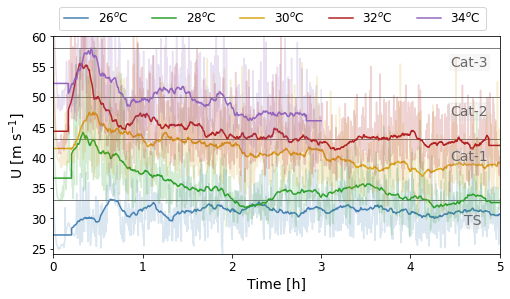

In [10]:
#%% Time series of maximum instantaneous wind speed at a given vertical level
# Limits for plot
limX = 1e8
for i_h in np.flip(np.arange(len(WRF_DIRS))): # For each hurricane
    if np.nanmax(time_ws[i_h,:]/3600)<limX:
        limX = np.nanmax(time_ws[i_h,:]/3600)
limX = 5
# Window for moving average
window_maxWS = 10*60 # [s]
nnn = int(window_maxWS/dt)

# Figure
mpyplot.figure(figsize=(8,4))
# Hurricane categories
# mpyplot.fill([0,limX,limX,0],[18,18,32.999,32.999],alpha=0.2,color='lightgrey')
# mpyplot.fill([0,limX,limX,0],[33,33,42.999,42.999],alpha=0.2,color='steelblue')
# mpyplot.fill([0,limX,limX,0],[43,43,49.999,49.999],alpha=0.2,color='gold')
# mpyplot.fill([0,limX,limX,0],[50,50,58,58],alpha=0.2,color='firebrick')
mpyplot.plot([0,limX],[18,18],'-k',linewidth=0.5)
mpyplot.plot([0,limX],[33,33],'-k',linewidth=0.5)
mpyplot.plot([0,limX],[43,43],'-k',linewidth=0.5)
mpyplot.plot([0,limX],[50,50],'-k',linewidth=0.5)
mpyplot.plot([0,limX],[58,58],'-k',linewidth=0.5)
# Data from hurricanes
limY = 0
for i_h in np.arange(len(WRF_DIRS)): #np.flip(np.arange(len(WRF_DIRS))): # For each hurricane
    # Extract data
    ws = max_ws[i_h,:]
    ts = time_ws[i_h,:]
    # Only plot 3-hr of data for 34 C hurricane
    if '34' in labels[i_h]:
        ws[ts>3*3600] = np.nan
        ts[ts>3*3600] = np.nan
    # Remove NaNs
    ts = ts[np.logical_not(np.isnan(ts))]/3600
    ws = ws[np.logical_not(np.isnan(ws))]
    ws_mv = moving_average(ws,nnn,'same')
    # plot data
    mpyplot.plot(ts,ws,color=cols[i_h],alpha=0.2)
    mpyplot.plot(ts,ws_mv,color=cols[i_h],label=labels[i_h])
    if np.max(ws)>limY:
        limY = np.max(ws)
# Annotate
# mpyplot.text(0.02*limX,56-1,'Cat-3',fontsize=14,color='firebrick'
#              ,bbox=dict(boxstyle="square,pad=0.1",fc="lightcoral", ec="lightcoral", lw=0,alpha=1))
# mpyplot.text(0.02*limX,48-1,'Cat-2',fontsize=14,color='darkgoldenrod'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="khaki", ec="khaki", lw=2,alpha=1))
# mpyplot.text(0.02*limX,41-1,'Cat-1',fontsize=14,color='steelblue'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="skyblue", ec="skyblue", lw=0,alpha=1)) 
# mpyplot.text(0.02*limX,31-1,'TS',fontsize=14,color='dimgrey'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgray", lw=0,alpha=1))
mpyplot.text(limX-0.11*limX,56-1,'Cat-3',fontsize=14,color='dimgrey'
             ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgrey", lw=0,alpha=0.2))
mpyplot.text(limX-0.11*limX,48-1,'Cat-2',fontsize=14,color='dimgrey'
            ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgrey", lw=2,alpha=0.2))
mpyplot.text(limX-0.11*limX,41-1.5,'Cat-1',fontsize=14,color='dimgrey'
            ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgrey", lw=0,alpha=0.2)) 
mpyplot.text(limX-0.08*limX,31-2,'TS',fontsize=14,color='dimgrey'
            ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgray", lw=0,alpha=0.2))
mpyplot.xlim(0,limX)
mpyplot.ylim(np.nanmin(max_ws),1.1*limY)
# mpyplot.xlim(0,4)
mpyplot.ylim(np.nanmin(max_ws),60)
mpyplot.xlabel('Time [h]',fontsize=14)
mpyplot.ylabel(r'U [m s$^{-1}$]',fontsize=14)
mpyplot.xticks(fontsize=12)
mpyplot.yticks(fontsize=12)
# mpyplot.legend(ncol=2,loc=3)
mpyplot.legend(fontsize=12,loc=3,ncol=5,bbox_to_anchor=[0.0, 1])

mpyplot.savefig(dirFig + "les_mws_spinup.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')

<ipython-input-11-8e33a377fda6>:32: RuntimeWarning: invalid value encountered in greater
  ws[ts>3*3600] = np.nan
<ipython-input-11-8e33a377fda6>:33: RuntimeWarning: invalid value encountered in greater
  ts[ts>3*3600] = np.nan


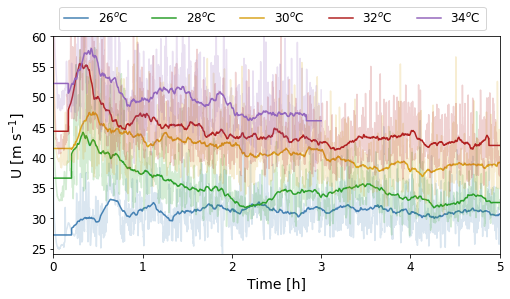

In [11]:
#%% Time series of maximum instantaneous wind speed at a given vertical level
# Limits for plot
limX = 1e8
for i_h in np.flip(np.arange(len(WRF_DIRS))): # For each hurricane
    if np.nanmax(time_ws[i_h,:]/3600)<limX:
        limX = np.nanmax(time_ws[i_h,:]/3600)
limX = 5
# Window for moving average
window_maxWS = 10*60 # [s]
nnn = int(window_maxWS/dt)

# Figure
mpyplot.figure(figsize=(8,4))
# Hurricane categories
# mpyplot.fill([0,limX,limX,0],[18,18,32.999,32.999],alpha=0.2,color='lightgrey')
# mpyplot.fill([0,limX,limX,0],[33,33,42.999,42.999],alpha=0.2,color='steelblue')
# mpyplot.fill([0,limX,limX,0],[43,43,49.999,49.999],alpha=0.2,color='gold')
# mpyplot.fill([0,limX,limX,0],[50,50,58,58],alpha=0.2,color='firebrick')
# mpyplot.plot([0,limX],[18,18],'-k',linewidth=0.5)
# mpyplot.plot([0,limX],[33,33],'-k',linewidth=0.5)
# mpyplot.plot([0,limX],[43,43],'-k',linewidth=0.5)
# mpyplot.plot([0,limX],[50,50],'-k',linewidth=0.5)
# mpyplot.plot([0,limX],[58,58],'-k',linewidth=0.5)
# Data from hurricanes
limY = 0
for i_h in np.arange(len(WRF_DIRS)): #np.flip(np.arange(len(WRF_DIRS))): # For each hurricane
    # Extract data
    ws = max_ws[i_h,:]
    ts = time_ws[i_h,:]
    # Only plot 3-hr of data for 34 C hurricane
    if '34' in labels[i_h]:
        ws[ts>3*3600] = np.nan
        ts[ts>3*3600] = np.nan
    # Remove NaNs
    ts = ts[np.logical_not(np.isnan(ts))]/3600
    ws = ws[np.logical_not(np.isnan(ws))]
    ws_mv = moving_average(ws,nnn,'same')
    # plot data
    mpyplot.plot(ts,ws,color=cols[i_h],alpha=0.2)
    mpyplot.plot(ts,ws_mv,color=cols[i_h],label=labels[i_h])
    if np.max(ws)>limY:
        limY = np.max(ws)
# Annotate
# mpyplot.text(0.02*limX,56-1,'Cat-3',fontsize=14,color='firebrick'
#              ,bbox=dict(boxstyle="square,pad=0.1",fc="lightcoral", ec="lightcoral", lw=0,alpha=1))
# mpyplot.text(0.02*limX,48-1,'Cat-2',fontsize=14,color='darkgoldenrod'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="khaki", ec="khaki", lw=2,alpha=1))
# mpyplot.text(0.02*limX,41-1,'Cat-1',fontsize=14,color='steelblue'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="skyblue", ec="skyblue", lw=0,alpha=1)) 
# mpyplot.text(0.02*limX,31-1,'TS',fontsize=14,color='dimgrey'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgray", lw=0,alpha=1))
# mpyplot.text(limX-0.11*limX,56-1,'Cat-3',fontsize=14,color='dimgrey'
#              ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgrey", lw=0,alpha=0.2))
# mpyplot.text(limX-0.11*limX,48-1,'Cat-2',fontsize=14,color='dimgrey'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgrey", lw=2,alpha=0.2))
# mpyplot.text(limX-0.11*limX,41-1.5,'Cat-1',fontsize=14,color='dimgrey'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgrey", lw=0,alpha=0.2)) 
# mpyplot.text(limX-0.08*limX,31-2,'TS',fontsize=14,color='dimgrey'
#             ,bbox=dict(boxstyle="square,pad=0.1",fc="lightgrey", ec="lightgray", lw=0,alpha=0.2))
mpyplot.xlim(0,limX)
mpyplot.ylim(np.nanmin(max_ws),1.1*limY)
# mpyplot.xlim(0,4)
mpyplot.ylim(np.nanmin(max_ws),60)
mpyplot.xlabel('Time [h]',fontsize=14)
mpyplot.ylabel(r'U [m s$^{-1}$]',fontsize=14)
mpyplot.xticks(fontsize=12)
mpyplot.yticks(fontsize=12)
# mpyplot.legend(ncol=2,loc=3)
mpyplot.legend(fontsize=12,loc=3,ncol=5,bbox_to_anchor=[0.0, 1])

mpyplot.savefig(dirFig + "les_mws_spinup_noCat.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')